<a href="https://colab.research.google.com/github/667029/dat158-ML-assignment2/blob/main/DAT158ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 DAT158

*Modeller vi bruker: Random Forrest for regresjon*

***Måling av modellens ytelse:***

Vi skal bruke både metrikker som **Root Mean Squared Error** (RMSE) og **Mean Absolute Error** (MAE) Da disse vil gi oss en helhetlig forståelse av modellens **nøyaktighet**. En kombinasjon av disse gir innsikt i gjennomsnittlig feilmargin og risikoen for store feil(avvik).


**Hovedsteg:**
1. Datainnsamling (hentes fra Kaggle)
2. Preprossesering av data
- 2.1 Rense data
- 2.2 Feature Engineering
- 2.3 Normalisre data om nødvendig
3. Train_validate_test
4. Modelltrening
5. Modellvalidering
- 5.1 Optimalisere hyperparametre
6. Modelltesting på nye data
7. Implementere modellen i Gradio



In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sklearn

# Datainnsamling


In [10]:
train_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_train.csv"
test_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_test.csv"

train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

In [20]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               14105 non-null  object 
 1   price              14105 non-null  float64
 2   bedrooms           14105 non-null  int64  
 3   grade              14105 non-null  int64  
 4   has_basement       14105 non-null  bool   
 5   living_in_m2       14105 non-null  float64
 6   renovated          14105 non-null  bool   
 7   nice_view          14105 non-null  bool   
 8   perfect_condition  14105 non-null  bool   
 9   real_bathrooms     14105 non-null  int64  
 10  has_lavatory       14105 non-null  bool   
 11  single_floor       14105 non-null  bool   
 12  month              14105 non-null  int64  
 13  quartile_zone      14105 non-null  int64  
dtypes: bool(6), float64(2), int64(5), object(1)
memory usage: 964.3+ KB


# Preprosessering av data


"Date" er av typen String og må konverteres til Datetime

<Axes: >

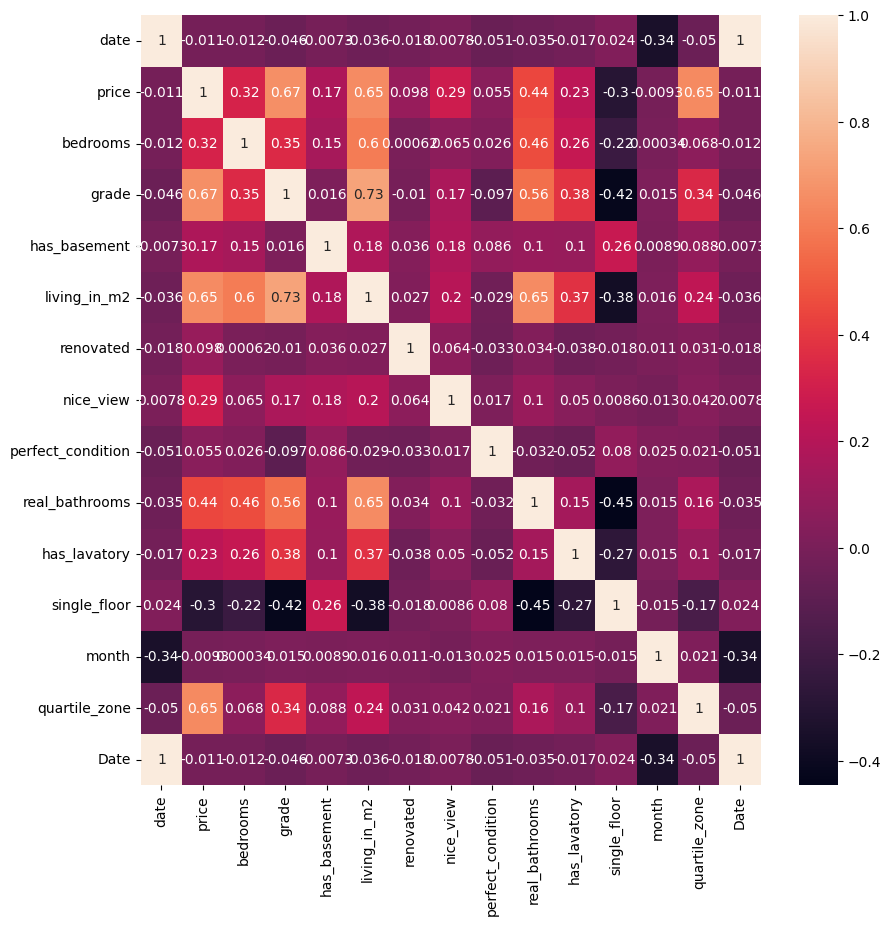

In [25]:
train_data["date"] = pd.to_datetime(train_data["date"])
test_data["date"] = pd.to_datetime(test_data["date"])

plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(), annot=True)
